In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from datetime import timedelta
from datetime import date
import math
# get the number of days between min and max dates
# then calculate the number of periods by dividing the number of 
# days by the number of datapoints and finally calculate 
# new dates with equal distance between them

def get_new_dates(df):
    dates = []
    for study_type in df.Type.unique():
        days_between = (max(df[df.Type==study_type]['Date']) - min(df[df.Type==study_type]['Date'])).days
        period = math.ceil(days_between/(len(df[df.Type==study_type])-1))
        list_dates = [min(df[df.Type==study_type]['Date'])]                  
        for i in range(len(df[df.Type==study_type])-1):
            list_dates.append(list_dates[-1] + timedelta(days=period))
        dates.extend(list_dates)
    return dates

def credits_cumsum(df):
    cumsum = []
    for study_type in df.Type.unique():
        local_cumsum = df[df.Type==study_type]['Credits'].cumsum().values
        cumsum.extend(local_cumsum)
    return cumsum

def moving_avg_grade(df, min_periods=1):
    new_average = []
    for study_type in df.Type.unique():
        local_average = df[df.Type==study_type]['Grade'].expanding(min_periods=min_periods).mean().values
        new_average.extend(local_average)
    return new_average

def moving_avg_avg(df, min_periods=1):
    new_average = []
    for study_type in df.Type.unique():
        local_average = df[df.Type==study_type]['Average'].expanding(min_periods=min_periods).mean().values
        new_average.extend(local_average)
    return new_average

def print_general_stats(df):
    print('European Credits:\n')
    print("Psychology Bachelor: \t\t{}".format(sum(df[df.Type=='BA'].Credits)))
    print("I/O Psychology Master: \t\t{}".format(sum(df[df.Type=='IO'].Credits)))
    print("Clinical Psychology Premaster:\t{}".format(sum(df[df.Type=='PM-CL'].Credits)))
    print("Clinical Psychology Master: \t{}".format(sum(df[df.Type=='CL'].Credits)))
    print("Data Science Premaster: \t{}".format(sum(df[df.Type=='PM-DS'].Credits)))
    print("Data Science Master: \t\t{}".format(sum(df[df.Type=='DS'].Credits)))
    print("Total number of credits: \t{}".format(sum(df.Credits)))
    print('Unweighted average:\n')
    print("Psychology Bachelor: \t\t{}".format(round(np.mean(df[(df.Type=='BA') & (df.Grade != 'P')].Grade), 2)))
    print("I/O Psychology Master: \t\t{}".format(round(np.mean(df[df.Type=='IO'].Grade), 2)))
    print("Clinical Psychology Premaster:\t{}".format(round(np.mean(df[df.Type=='PM-CL'].Grade), 2)))
    print("Clinical Psychology Master: \t{}".format(round(np.mean(df[df.Type=='CL'].Grade), 2)))
    print("Data Science Premaster: \t{}".format(round(np.mean(df[df.Type=='PM-DS'].Grade), 2)))
    print("Data Science Master: \t\t{}".format(round(np.mean(df[df.Type=='DS'].Grade), 2)))
    print("Total number of credits (including bachelor): \t{}".format(round(np.mean(df[(df.Grade != 'P')].Grade), 2)))
    print("Total number of credits (excluding bachelor): \t{}".format(round(np.mean(df[(df.Grade != 'P') &
                                                                                      (df.Type != 'BA')].Grade), 2)))
    
def plot_histogram(df):
    df = df.sort_values('Date')
    to_plot = df.loc[df.Grade!='P', :].copy()
    to_plot['new_date'] = get_new_dates(to_plot)
    to_plot['mov_grade'] = moving_avg_grade(to_plot)
    to_plot['mov_avg'] = moving_avg_avg(to_plot)

    fig, ax = plt.subplots()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 10

    for i, study_type in enumerate(df.Type.unique()):
        plt.bar(to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].new_date.values, 
                    to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].Grade.values.astype(float), 40,
                    color=colors[i], label=study_type)

    plt.ylim(ymin=5.8, ymax=10.1)
    fig.set_size_inches(15, 7)
    plt.legend()
    plt.show()
    # plt.savefig('test.png', dpi=300)

In [2]:
df = pd.read_excel('grades_date_inaccurate.xlsx')
df.Date = pd.to_datetime(df.Date)
df.Course = df.apply(lambda row: row.Course.split('(')[0], 1)
df = df.sort_values('Date')

### General Stats

In [3]:
print_general_stats(df)

European Credits:

Psychology Bachelor: 		180
I/O Psychology Master: 		60
Clinical Psychology Premaster:	36
Clinical Psychology Master: 	60
Data Science Premaster: 	30
Data Science Master: 		78
Total number of credits: 	444
Unweighted average:

Psychology Bachelor: 		6.91
I/O Psychology Master: 		8.29
Clinical Psychology Premaster:	8.08
Clinical Psychology Master: 	8.5
Data Science Premaster: 	9.2
Data Science Master: 		8.38
Total number of credits (including bachelor): 	7.77
Total number of credits (excluding bachelor): 	8.45


### Largest difference

In [4]:
df['difference'] = df.apply(lambda row: row.Grade-row.Average if type(row.Grade)!=str else None, 1)
print('Largest difference:')
print(df[df.difference == df.difference.max()])

print('Smallest difference:')
print(df[df.difference == df.difference.min()])

to_plot_diff = pd.DataFrame(columns=["Course", "Grade", "Average", "Difference"])
small = list(df[df.difference == df.difference.min()][['Course', 'Grade', 'Average']].values[0])
big = list(df[df.difference == df.difference.max()][['Course', 'Grade', 'Average']].values[0])
to_plot_diff.loc[len(to_plot_diff)] = small + ['Small']
to_plot_diff.loc[len(to_plot_diff)] = big + ['Big']

Largest difference:
                 Course       Date Grade  Credits Type  Average  difference
37  Clinical Psychology 2015-10-01     9        6   CL      6.5         2.5
Smallest difference:
                   Course       Date Grade  Credits Type  Average  difference
38  Work Group Psychology 2013-12-16   8.5        6   IO     8.28        0.22


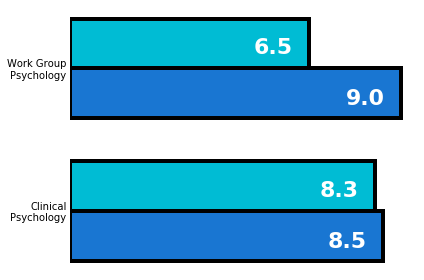

In [5]:
import numpy as np
import matplotlib.pyplot as plt
 
# data to plot
n_groups = 2
grades = to_plot_diff.Grade.values
average = to_plot_diff.Average.values
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.barh(index, grades, bar_width,alpha=opacity,color='#1976d2',
                 label='My Grade',edgecolor = "black", linewidth=4)
rects2 = plt.barh(index + bar_width, average, bar_width,alpha=opacity,color='#00bcd4',
                 label="Students' Average",edgecolor = "black", linewidth=4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks([])

for i, v in enumerate(grades):
    ax.text(v-1.5, i-0.08, str(v), color='white', fontweight='bold', fontsize=22)
for i, v in enumerate(average):
    ax.text(v-1.5, i+0.28, str(round(v, 1)), color='white', fontweight='bold', fontsize=22)

# plt.title('Smallest and largest difference between \n') # my grade and the average
# plt.text(0.3,9.65, 'my grade', fontsize=12,color='#1976d2')
# plt.text(0.6,9.65, 'and', fontsize=12)
# plt.text(0.74,9.65, 'the average', fontsize=12,color='#00bcd4')
plt.yticks(index + bar_width/2, to_plot_diff.Course.values)
ax.set_yticklabels(['Clinical\nPsychology', 'Work Group\nPsychology'])
# plt.legend()\
plt.tight_layout()
# plt.savefig('bar_difference.png',dpi=600, transparent=True)
plt.show()

### Visualization

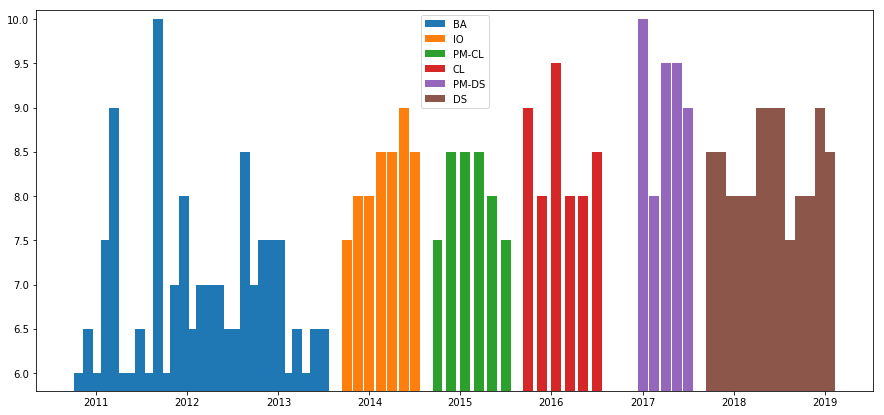

In [6]:
plot_histogram(df)

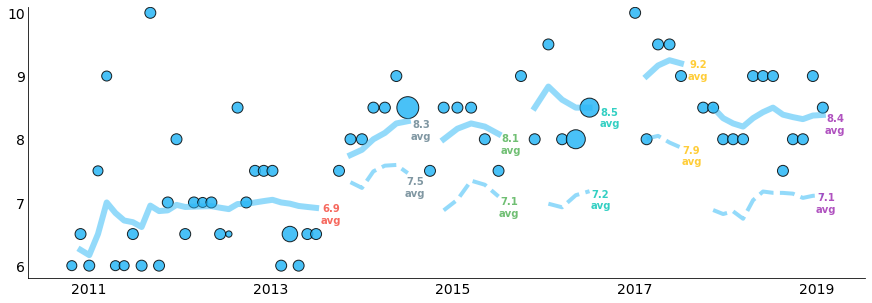

In [7]:
df = df.sort_values('Date')
to_plot = df.loc[df.Grade!='P', :].copy()
to_plot['new_date'] = get_new_dates(to_plot)
to_plot['mov_grade'] = moving_avg_grade(to_plot, min_periods=2)
to_plot['mov_avg'] = moving_avg_avg(to_plot, min_periods=2)
to_plot['cumsum_credits'] = credits_cumsum(to_plot)

fig, ax = plt.subplots(figsize=(15, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 10
colors = ['#f44336','#607d8b','#4caf50','#00C4B4','#ffc107','#9c27b0']
colors = ['#03a9f4', '#29b6f6', '#4fc3f7', '#81d4fa', '#b3e5fc', '#e1f5fe']
colors.reverse()
colors = ['#29b6f6', '#29b6f6', '#29b6f6', '#29b6f6', '#29b6f6', '#29b6f6']

for i, study_type in enumerate(to_plot.Type.unique()):
    plt.scatter(to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].new_date.values, 
                to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].Grade.values.astype(float), 
                color=colors[i], alpha=.85, label=study_type, linewidth=1, edgecolor='black',
               s=to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].Credits.values*20)
    plt.plot(to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].new_date.values, 
                to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].mov_grade.values.astype(float), 
                color=colors[i], alpha=0.5, label=study_type, linewidth=6)
    plt.plot(to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].new_date.values, 
                to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].mov_avg.values.astype(float), 
                '--', color=colors[i], alpha=0.5, label=study_type, linewidth=4)
    
plt.ylim(ymin=5.8, ymax=10.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# # Add names of education
# plt.text(date(2012,1,1), 10.2, 'Bachelor\nPsychology', fontsize=12, color='black', 
#          horizontalalignment='center', fontweight='bold')
# plt.text(date(2014,1,18), 9.2, 'Master\n IO Psychology', fontsize=12, color='black', 
#         horizontalalignment='center', fontweight='bold')
# plt.text(date(2015,1,25), 8.8, 'Pre-master\nClinical Psychology', fontsize=12, color='black', 
#          horizontalalignment='center', fontweight='bold')
# plt.text(date(2016,2,10), 9.8, 'Master\nClinical Psychology', fontsize=12, color='black', 
#         horizontalalignment='center', fontweight='bold')
# plt.text(date(2017,3,10), 10.2, 'Pre-master\nData Science', fontsize=12, color='black', 
#         horizontalalignment='center', fontweight='bold')
# plt.text(date(2018,6,1), 9.2, 'Master\nData Science', fontsize=12, color='black',
#         horizontalalignment='center', fontweight='bold')

# Add averages of my own grades
plt.text(date(2013,8,30), 6.67, 
         str(round(to_plot.loc[to_plot.Type=='BA', 'Grade'].mean(), 1))+'\navg', 
         fontsize=10, color='#f44336', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2014,8,25), 8, 
         str(round(to_plot.loc[to_plot.Type=='IO', 'Grade'].mean(), 1))+'\navg', 
         fontsize=10, color='#607d8b', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2015,8,20), 7.78, 
         str(round(to_plot.loc[to_plot.Type=='PM-CL', 'Grade'].mean(), 1))+'\navg', 
         fontsize=10, color='#4caf50', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2016,9,20), 8.2, 
         str(round(to_plot.loc[to_plot.Type=='CL', 'Grade'].mean(), 1))+'\navg', 
         fontsize=10, color='#00C4B4', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2017,9,10), 8.95, 
         str(round(to_plot.loc[to_plot.Type=='PM-DS', 'Grade'].mean(), 1))+'\navg', 
         fontsize=10, color='#ffc107', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2019,3,15), 8.1, 
         str(round(to_plot.loc[to_plot.Type=='DS', 'Grade'].mean(), 1))+'\navg', 
         fontsize=10, color='#9c27b0', horizontalalignment='center', alpha=0.8, fontweight='bold')

# add averages of average
plt.text(date(2014,8,1), 7.1, 
         str(round(to_plot.loc[to_plot.Type=='IO', 'Average'].mean(), 1))+'\navg', 
         fontsize=10, color='#607d8b', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2015,8,15), 6.78, 
         str(round(to_plot.loc[to_plot.Type=='PM-CL', 'Average'].mean(), 1))+'\navg', 
         fontsize=10, color='#4caf50', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2016,8,15), 6.9, 
         str(round(to_plot.loc[to_plot.Type=='CL', 'Average'].mean(), 1))+'\navg', 
         fontsize=10, color='#00C4B4', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2017,8,15), 7.6, 
         str(round(to_plot.loc[to_plot.Type=='PM-DS', 'Average'].mean(), 1))+'\navg', 
         fontsize=10, color='#ffc107', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2019,2,5), 6.85, 
         str(round(to_plot.loc[to_plot.Type=='DS', 'Average'].mean(), 1))+'\navg', 
         fontsize=10, color='#9c27b0', horizontalalignment='center', alpha=0.8, fontweight='bold')

# color axes
# ax.spines['bottom'].set_color('#dddddd')
# ax.spines['left'].set_color('#dddddd')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticks([date(2011+(i),1,1) for i in np.arange(0, 10, 2)])
ax.set_yticks(np.arange(6, 11, 1))

# Create custom legend
cmap = plt.cm.coolwarm

custom_lines = [Line2D([0], [0], color='black', markersize=12,marker='o',markerfacecolor='#dddddd',
                      markeredgewidth=1.5),
                Line2D([0], [0], color='#dddddd', lw=4),
                Line2D([0], [0], color='#dddddd', lw=6,linestyle='--')]
# ax.legend(custom_lines, ['My Grade', 'My Average', "Students' Average"],
#          fontsize=16)|

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.show()
# plt.savefig('grades_viz_sizes_v2.png', dpi=600, transparent=True)

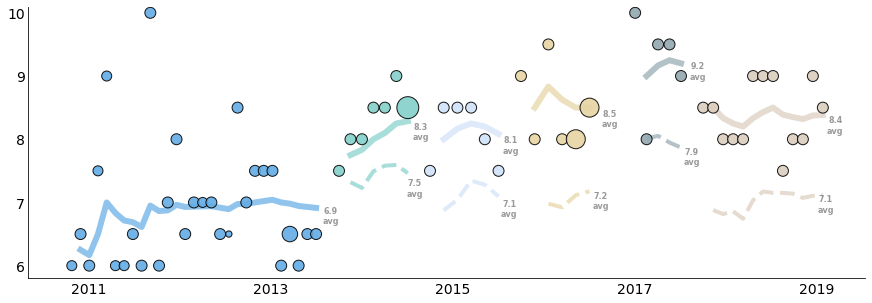

In [8]:
df = df.sort_values('Date')
to_plot = df.loc[df.Grade!='P', :].copy()
to_plot['new_date'] = get_new_dates(to_plot)
to_plot['mov_grade'] = moving_avg_grade(to_plot, min_periods=2)
to_plot['mov_avg'] = moving_avg_avg(to_plot, min_periods=2)
to_plot['cumsum_credits'] = credits_cumsum(to_plot)
# df.loc[:, 'Date'] = df['Date'].dt.strftime("%Y%m%d").astype(int)

fig, ax = plt.subplots(figsize=(15, 5))
colors = ['#63ace5', '#83d0c9', '#d0e1f9', '#e6d4a2', '#93a8b0', '#dacdbe']
# colors = ['#dacdbe', '#63ace5', '#d0e1f9', '#e6d4a2', '#93a8b0', '#83d0c9']


# colors = ['#63ace5', '#83d0c9', '#e6d4a2', '#d0e1f9', '#93a8b0', '#dacdbe']

# colors = ['#63ace5', '#83d0c9', '#e6d4a2', '#d0e1f9', '#f0908a', '#dacdbe']


#4a707a

for i, study_type in enumerate(to_plot.Type.unique()):
    plt.scatter(to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].new_date.values, 
                to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].Grade.values.astype(float), 
                color=colors[i], alpha=.9, label=study_type, linewidth=1, edgecolor='black',
               s=to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].Credits.values*20)
    plt.plot(to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].new_date.values, 
                to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].mov_grade.values.astype(float), 
                color=colors[i], alpha=0.7, label=study_type, linewidth=6, zorder=0)
    plt.plot(to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].new_date.values, 
                to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].mov_avg.values.astype(float), 
                '--', color=colors[i], alpha=0.7, label=study_type, linewidth=4, zorder=0)
    
plt.ylim(ymin=5.8, ymax=10.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# # Add names of education
# plt.text(date(2012,1,1), 10.2, 'Bachelor\nPsychology', fontsize=12, color='black', 
#          horizontalalignment='center', fontweight='bold')
# plt.text(date(2014,1,18), 9.2, 'Master\n IO Psychology', fontsize=12, color='black', 
#         horizontalalignment='center', fontweight='bold')
# plt.text(date(2015,1,25), 8.8, 'Pre-master\nClinical Psychology', fontsize=12, color='black', 
#          horizontalalignment='center', fontweight='bold')
# plt.text(date(2016,2,10), 9.8, 'Master\nClinical Psychology', fontsize=12, color='black', 
#         horizontalalignment='center', fontweight='bold')
# plt.text(date(2017,3,10), 10.2, 'Pre-master\nData Science', fontsize=12, color='black', 
#         horizontalalignment='center', fontweight='bold')
# plt.text(date(2018,6,1), 9.2, 'Master\nData Science', fontsize=12, color='black',
#         horizontalalignment='center', fontweight='bold')

# Add averages of my own grades
plt.text(date(2013,8,30), 6.67, 
         str(round(to_plot.loc[to_plot.Type=='BA', 'Grade'].mean(), 1))+'\navg', 
         fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2014,8,25), 8, 
         str(round(to_plot.loc[to_plot.Type=='IO', 'Grade'].mean(), 1))+'\navg', 
         fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2015,8,20), 7.78, 
         str(round(to_plot.loc[to_plot.Type=='PM-CL', 'Grade'].mean(), 1))+'\navg', 
         fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2016,9,20), 8.2, 
         str(round(to_plot.loc[to_plot.Type=='CL', 'Grade'].mean(), 1))+'\navg', 
         fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2017,9,10), 8.95, 
         str(round(to_plot.loc[to_plot.Type=='PM-DS', 'Grade'].mean(), 1))+'\navg', 
         fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2019,3,15), 8.1, 
         str(round(to_plot.loc[to_plot.Type=='DS', 'Grade'].mean(), 1))+'\navg', 
         fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')

# add averages of average
plt.text(date(2014,8,1), 7.1, 
         str(round(to_plot.loc[to_plot.Type=='IO', 'Average'].mean(), 1))+'\navg', 
         fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2015,8,15), 6.78, 
         str(round(to_plot.loc[to_plot.Type=='PM-CL', 'Average'].mean(), 1))+'\navg', 
         fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2016,8,15), 6.9, 
         str(round(to_plot.loc[to_plot.Type=='CL', 'Average'].mean(), 1))+'\navg', 
         fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2017,8,15), 7.6, 
         str(round(to_plot.loc[to_plot.Type=='PM-DS', 'Average'].mean(), 1))+'\navg', 
         fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
plt.text(date(2019,2,5), 6.85, 
         str(round(to_plot.loc[to_plot.Type=='DS', 'Average'].mean(), 1))+'\navg', 
         fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')

# color axes
# ax.spines['bottom'].set_color('#dddddd')
# ax.spines['left'].set_color('#dddddd')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticks([date(2011+(i),1,1) for i in np.arange(0, 10, 2)])
ax.set_yticks(np.arange(6, 11, 1))

# Create custom legend
cmap = plt.cm.coolwarm

custom_lines = [Line2D([0], [0], color='black', markersize=12,marker='o',markerfacecolor='#dddddd',
                      markeredgewidth=1.5),
                Line2D([0], [0], color='#dddddd', lw=4),
                Line2D([0], [0], color='#dddddd', lw=6,linestyle='--')]
# ax.legend(custom_lines, ['My Grade', 'My Average', "Students' Average"],
#          fontsize=16)|

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.show()
# plt.savefig('grades_viz_sizes_temp.png', dpi=600, transparent=True)

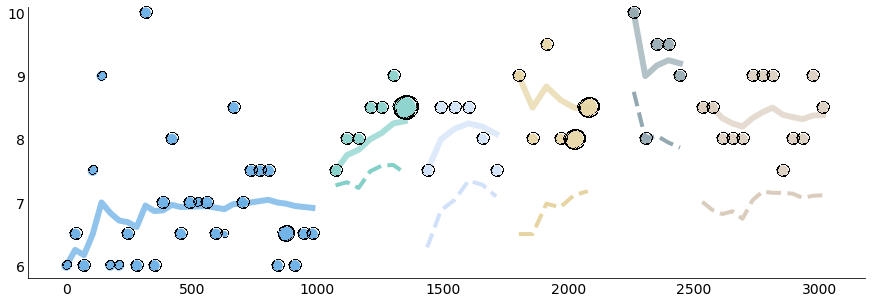

In [9]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

df = df.sort_values('Date')
to_plot = df.loc[df.Grade!='P', :].copy()
to_plot['new_date'] = get_new_dates(to_plot)
to_plot['mov_grade'] = moving_avg_grade(to_plot, min_periods=1)
to_plot['mov_avg'] = moving_avg_avg(to_plot, min_periods=1)
to_plot['cumsum_credits'] = credits_cumsum(to_plot)
to_plot['date_int'] = to_plot[['new_date']].diff()
to_plot['date_int'] = to_plot[['date_int']].dropna().apply(lambda row: 
                                                                           row.date_int.days, 1)
to_plot['date_int'] = to_plot.date_int.fillna(0).values
to_plot['date_int'] = to_plot['date_int'].cumsum()

fig, ax = plt.subplots(figsize=(15, 5))
colors = ['#63ace5', '#83d0c9', '#d0e1f9', '#e6d4a2', '#93a8b0', '#dacdbe']
# colors = ['#dacdbe', '#63ace5', '#d0e1f9', '#e6d4a2', '#93a8b0', '#83d0c9']
# colors = ['#63ace5', '#83d0c9', '#e6d4a2', '#d0e1f9', '#93a8b0', '#dacdbe']
# colors = ['#63ace5', '#83d0c9', '#e6d4a2', '#d0e1f9', '#f0908a', '#dacdbe']


for i, study_type in enumerate(to_plot.Type.unique()):
    plt.scatter(to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].date_int.values, 
                to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].Grade.values.astype(float), 
                color=colors[i], alpha=.9, label=study_type, linewidth=0, edgecolor='black',
               s=to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].Credits.values*20)
    plt.plot(to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].date_int.values, 
                to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].mov_grade.values.astype(float), 
                color=colors[i], alpha=0.7, label=study_type, linewidth=6, zorder=0)
    plt.plot(to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].date_int.values, 
                to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].mov_avg.values.astype(float), 
                '--', color=colors[i], alpha=1, label=study_type, linewidth=4, zorder=0)
    x = to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].date_int.values
    y = to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].Grade.values.astype(float)
    sizes = to_plot[(to_plot.Grade!='P')&(to_plot.Type==study_type)].Credits.values
    size_dict = {2:0.01, 5:0.011, 6:0.015, 12:0.02, 18:0.025, 24:0.03}
    for x_i, y_i, size in zip(x, y, sizes):
        imscatter(x_i, y_i, 'circle_3.png', zoom=size_dict[size], ax=ax)



    
plt.ylim(ymin=5.8, ymax=10.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# # Add names of education
# plt.text(date(2012,1,1), 10.2, 'Bachelor\nPsychology', fontsize=12, color='black', 
#          horizontalalignment='center', fontweight='bold')
# plt.text(date(2014,1,18), 9.2, 'Master\n IO Psychology', fontsize=12, color='black', 
#         horizontalalignment='center', fontweight='bold')
# plt.text(date(2015,1,25), 8.8, 'Pre-master\nClinical Psychology', fontsize=12, color='black', 
#          horizontalalignment='center', fontweight='bold')
# plt.text(date(2016,2,10), 9.8, 'Master\nClinical Psychology', fontsize=12, color='black', 
#         horizontalalignment='center', fontweight='bold')
# plt.text(date(2017,3,10), 10.2, 'Pre-master\nData Science', fontsize=12, color='black', 
#         horizontalalignment='center', fontweight='bold')
# plt.text(date(2018,6,1), 9.2, 'Master\nData Science', fontsize=12, color='black',
#         horizontalalignment='center', fontweight='bold')

# # Add averages of my own grades
# plt.text(date(2013,8,30), 6.67, 
#          str(round(to_plot.loc[to_plot.Type=='BA', 'Grade'].mean(), 1))+'\navg', 
#          fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
# plt.text(date(2014,8,25), 8, 
#          str(round(to_plot.loc[to_plot.Type=='IO', 'Grade'].mean(), 1))+'\navg', 
#          fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
# plt.text(date(2015,8,20), 7.78, 
#          str(round(to_plot.loc[to_plot.Type=='PM-CL', 'Grade'].mean(), 1))+'\navg', 
#          fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
# plt.text(date(2016,9,20), 8.2, 
#          str(round(to_plot.loc[to_plot.Type=='CL', 'Grade'].mean(), 1))+'\navg', 
#          fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
# plt.text(date(2017,9,10), 8.95, 
#          str(round(to_plot.loc[to_plot.Type=='PM-DS', 'Grade'].mean(), 1))+'\navg', 
#          fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
# plt.text(date(2019,3,15), 8.1, 
#          str(round(to_plot.loc[to_plot.Type=='DS', 'Grade'].mean(), 1))+'\navg', 
#          fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')

# # add averages of average
# plt.text(date(2014,8,1), 7.1, 
#          str(round(to_plot.loc[to_plot.Type=='IO', 'Average'].mean(), 1))+'\navg', 
#          fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
# plt.text(date(2015,8,15), 6.78, 
#          str(round(to_plot.loc[to_plot.Type=='PM-CL', 'Average'].mean(), 1))+'\navg', 
#          fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
# plt.text(date(2016,8,15), 6.9, 
#          str(round(to_plot.loc[to_plot.Type=='CL', 'Average'].mean(), 1))+'\navg', 
#          fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
# plt.text(date(2017,8,15), 7.6, 
#          str(round(to_plot.loc[to_plot.Type=='PM-DS', 'Average'].mean(), 1))+'\navg', 
#          fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')
# plt.text(date(2019,2,5), 6.85, 
#          str(round(to_plot.loc[to_plot.Type=='DS', 'Average'].mean(), 1))+'\navg', 
#          fontsize=8, color='grey', horizontalalignment='center', alpha=0.8, fontweight='bold')

# color axes
# ax.spines['bottom'].set_color('#dddddd')
# ax.spines['left'].set_color('#dddddd')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.set_xticks([date(2011+(i),1,1) for i in np.arange(0, 10, 2)])
ax.set_yticks(np.arange(6, 11, 1))

# Create custom legend
cmap = plt.cm.coolwarm

custom_lines = [Line2D([0], [0], color='black', markersize=12,marker='o',markerfacecolor='#dddddd',
                      markeredgewidth=1.5),
                Line2D([0], [0], color='#dddddd', lw=4),
                Line2D([0], [0], color='#dddddd', lw=6,linestyle='--')]
# ax.legend(custom_lines, ['My Grade', 'My Average', "Students' Average"],
#          fontsize=16)|

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.show()
# plt.savefig('circles_plot_full.png', dpi=600, transparent=True)

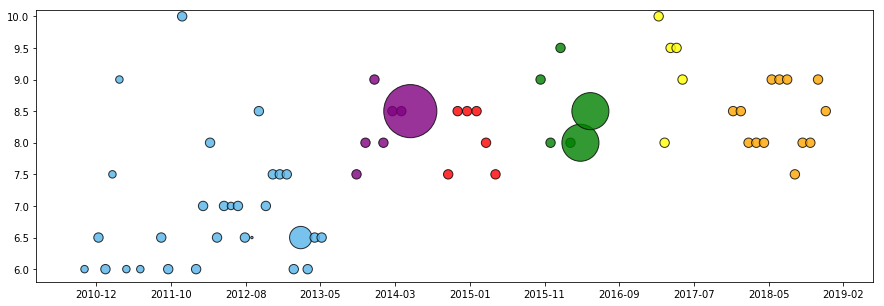

In [17]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 10
colors = ['#56b4e9', 'purple', 'red', 'green', 'yellow', 'orange']


for i, study_type in enumerate(df.Type.unique()):
    plt.scatter(df[(df.Grade!='P')&(df.Type==study_type)].Date.values, 
                df[(df.Grade!='P')&(df.Type==study_type)].Grade.values.astype(float), 
                color=colors[i], alpha=0.8, label=study_type, linewidth=1, 
                s=df[(df.Grade!='P')&(df.Type==study_type)].Credits.values**2.5, edgecolor='black')

plt.ylim(ymin=5.8, ymax=10.1)
fig.set_size_inches(15, 5)
# plt.legend()

# # # Set number of xticks
ax.xaxis.set_major_locator(mdates.DayLocator(interval=300))   #to get a tick every 60 days
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()
# plt.savefig('test.png', dpi=300)

** Compared to all other students **

15% of students achieved the same or a higher result.

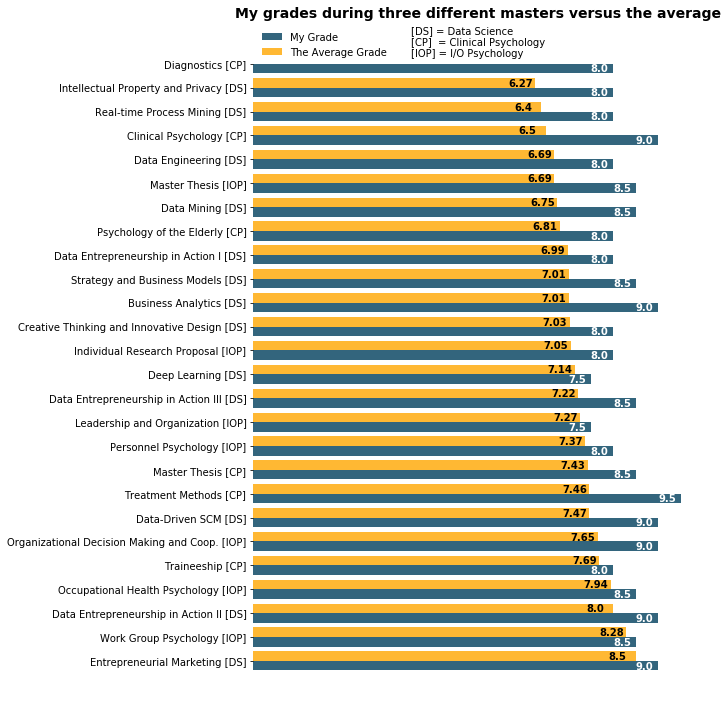

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


avg_df = avg_df.sort_values('Avg', ascending=False)

# to_plot = avg_df.loc[avg_df.Education=='MS-DS']
to_plot = avg_df

n_groups = len(to_plot)

my_scores = to_plot.My.values
avg_scores = to_plot.fillna(0).Avg.values


fig, ax = plt.subplots(figsize=(10, 10))

index = np.arange(n_groups)
bar_width = 0.4
opacity = .8

rects1 = ax.barh(index, my_scores, bar_width,
                alpha=opacity, color='#003f5c',
                label='My Grade')

rects2 = ax.barh(index + bar_width, avg_scores, bar_width,
                alpha=opacity, color='#ffa600',
                label='The Average Grade')


ax.set_title('My grades during three different masters versus the average', fontsize=14, fontweight='bold')
plt.text(3.5,25.5,'[DS] = Data Science \n[CP]  = Clinical Psychology \n[IOP] = I/O Psychology')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(to_plot.Course.values)
ax.legend(loc='upper left',frameon=False)

for i, v in enumerate(my_scores):
    ax.text(v-0.5, i, str(v), color='white', fontweight='bold', va='center', fontsize=10)

for i, v in enumerate(avg_scores):
    if v == 0:
        ax.text(v + .05, i+0.4, str(v), color='white', fontweight='bold', va='center')
    else:
        ax.text(v - .6, i+0.4, str(v), color='black', fontweight='bold', va='center')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])

fig.tight_layout()
plt.show()
# plt.savefig('scores.png', dpi=300)